# Decision tree


#### Import and clean data 

In [1]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score

from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display
from data_processing import prepare_data, split_data
from helper_functions import get_metrics

In [2]:
# Clean the data
data = prepare_data('healthcare-dataset-stroke-data.csv')

# Split the data into training, testing and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

### Basic model

In [4]:
def train_and_predict(training_data, training_labels, testing_data, min_split = 2):
    """
    This function trains an instance of the DecisionTreeClassifier based on input training data and training labels. It can be 
    given a custom minimum split, which is at 2 to start with. It returns the predicted labels for the training_data and the
    testing_data in a tuple.
    """
    # Make an instance of the DecisionTreeClassifier
    model = DecisionTreeClassifier(min_samples_split = min_split)
    
    # Fit the data to the model
    model.fit(training_data, training_labels)
    
    # Predict labels for training and testing data
    train_predict = model.predict(training_data)
    test_predict = model.predict(testing_data)
    
    # Return predictions over the training (to test model accuracy for learned data) and testing data
    return train_predict, test_predict

# Get the predictions
prediction_train, prediction_test = train_and_predict(train_data, train_labels, test_data)

# Print the accuracies
print("For the training data:")
train_acc, train_balacc = get_metrics(train_labels, prediction_train, verbose = True)

print("For the testing data")
test_acc, testbalacc = get_metrics(test_labels, prediction_test, verbose = True)

For the training data:
accuracy: 100.0000 % 

balanced accuracy: 100.0000 %
sensitivity: 1.0000
specificity: 1.0000 

confusion matrix: 
[[2822    0]
 [   0  122]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 91.2424 % 

balanced accuracy: 57.3872 %
sensitivity: 0.1961
specificity: 0.9517 

confusion matrix: 
[[886  45]
 [ 41  10]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Parameter optimization options
There are multiple ways to optimize a decision tree:
1. Early stopping &rarr; where to stop
2. Pruning &rarr; cutting leafs
3. Significance thresholding &rarr; stop splitting when information gain is insignificant 

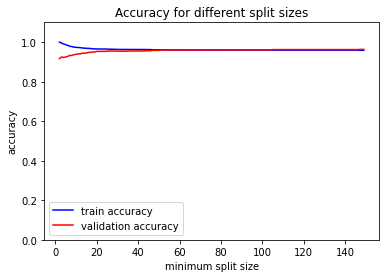

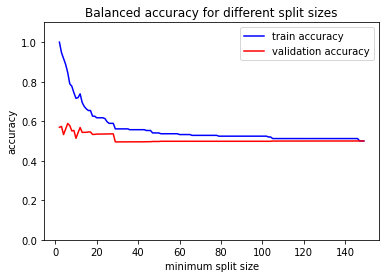

best split size: 6
highest validation accuracy: 0.5883838383838385


In [8]:
# Option 1. Early stopping: 
# Finding the optimal split for early stopping

def plot_accuracy(splits, training_acc, val_acc, title = "Accuracy for different split sizes"):
    """
    Plot the a list with an amount of splits and a list of measures of training and validation accuracy. Has the option of 
    setting a different title.
    """
    plt.plot(splits, training_acc, 'b')
    plt.plot(splits, val_acc, 'r')
    plt.xlabel('minimum split size')
    plt.ylabel('accuracy')
    plt.legend(['train accuracy', 'validation accuracy'])
    plt.ylim([0, 1.1])
    plt.title(title)
    plt.show()


# Try different minimal split sizes
min_splits = np.arange(2, 150)

# The accuracy for the various split sizes will be appended to this
train_accuracy = []
val_accuracy = []
train_accuracy_balanced = []
val_accuracy_balanced = []

# Loop over all minimum split sizes
for split_size in min_splits:
    
    # Create and fit model and predict labels
    train_predict, val_predict = train_and_predict(train_data, train_labels, val_data, min_split = split_size)
    
    # Get ccuracy for training and validation data
    train_acc, train_bal_acc = get_metrics(train_labels, train_predict)
    val_acc, val_bal_acc = get_metrics(val_labels, val_predict)
    
    # Append the accuracies to the lists
    train_accuracy.append(train_acc)
    train_accuracy_balanced.append(train_bal_acc)
    val_accuracy.append(val_acc)
    val_accuracy_balanced.append(val_bal_acc)
    
# Plot the findings
plot_accuracy(min_splits, train_accuracy, val_accuracy)
plot_accuracy(min_splits, train_accuracy_balanced, val_accuracy_balanced, title = "Balanced accuracy for different split sizes")

# Find the best split by finding the split that has the maximum validation accuracy
index_max = np.argmax(val_accuracy_balanced)
print(f'best split size: {min_splits[index_max]}')
print(f'highest validation accuracy: {val_accuracy_balanced[index_max]}')

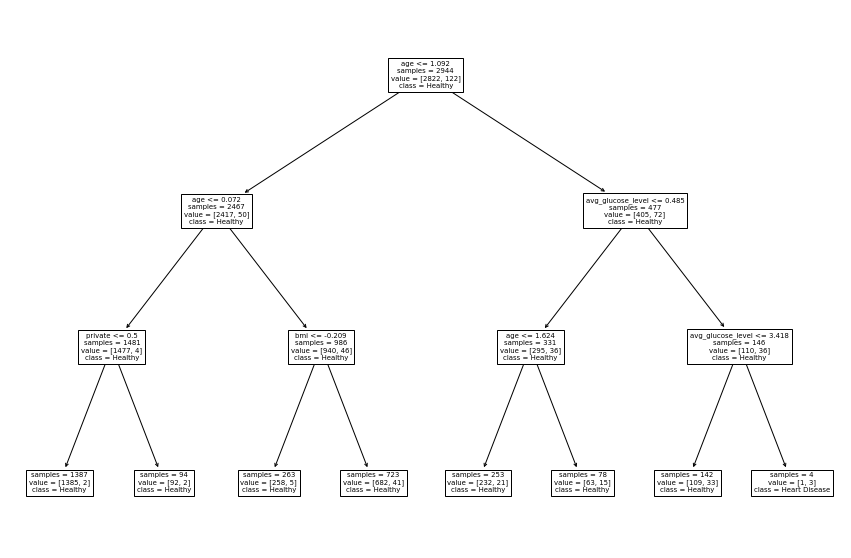

In [17]:
# Plot root of decision tree using this optimal split size, to see what this shows us about important features
d_tree = DecisionTreeClassifier(max_depth=3, min_samples_split=min_splits[index_max])
d_tree.fit(train_data, train_labels)

figure(figsize=(15, 10))
tree.plot_tree(d_tree, feature_names=data.columns.values, class_names=['Healthy', 'Heart Disease'], impurity=False);